Importando os dados

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Convertendo para Numpy

In [2]:
dados = np.fromfile('dataHoldout.txt', dtype=np.float64)
dados = dados.reshape(-1, 3)
print(dados)

[[-0.29322959 -0.09065359  1.        ]
 [ 0.07988839  0.21101297  1.        ]
 [-0.07825563 -0.08083512  1.        ]
 ...
 [ 0.65980493  1.05876739  0.        ]
 [ 1.09867123  0.87404891  0.        ]
 [ 0.72930655  0.93224271  0.        ]]


Plotando Gráfico

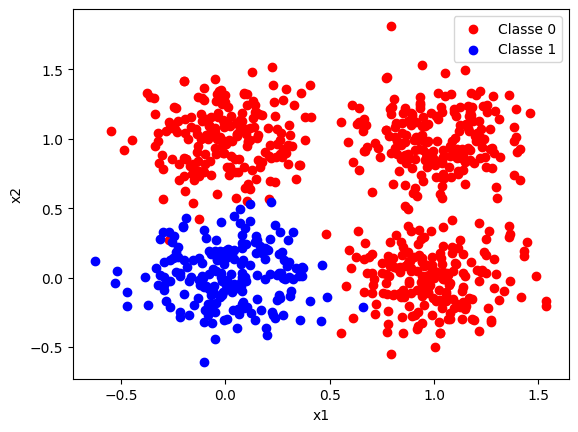

In [3]:
# Exemplo com classes
X = dados[:, :2]  # pega x1 e x2
y = dados[:, 2]   # pega yd

plt.scatter(X[y==0,0], X[y==0,1], c='red', label='Classe 0')
plt.scatter(X[y==1,0], X[y==1,1], c='blue', label='Classe 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

Dividir dataset

In [4]:
np.random.seed(4)

dados_aleatorios = np.random.permutation(dados)

#Dados de Treinamento 70%
dados_treinamento = dados_aleatorios[:int(0.7*len(dados_aleatorios))]

#Dados de Teste 30%
dados_teste = dados_aleatorios[int(0.7*len(dados_aleatorios)):]

Criar a classe do perceptron

In [26]:
class PerceptronRosenblat():
  def __init__(self):
    #Vies
    self.vies = 1
    #Ao iniciar a classe, os pesos são atribuidos de forma randomica
    self.pesos= np.array([np.random.uniform(-0.5,0.5),np.random.uniform(-0.5,0.5),np.random.uniform(-0.5,0.5)])
    self.taxa_de_aprendizado = 0.1

  def adicionar_vies(self, dados):
    for x in dados:
      dados_com_vies = np.array([np.insert(x, 0, self.vies) for x in dados])
    return dados_com_vies

  def funcao_ativacao_degrau(self, u):
    if u >= 0:
      return 1
    else:
      return 0

  def calcular_previsao(self,entradas):
    previsao = np.sum(entradas*self.pesos)

    return self.funcao_ativacao_degrau(float(previsao))

  def reajustar_pesos(self,entradas, saida, saida_desejada):
    novos_peso = self.pesos + self.taxa_de_aprendizado*(saida_desejada-saida)*entradas
    self.pesos = novos_peso

  def treinar(self, dados, epocas):
    dados = self.adicionar_vies(dados)

    for epoca in range(epocas):
      for x in dados:
        prever = self.calcular_previsao(x[:3])

        #Caso errar a previsão
        if(prever != x[3]):
          self.reajustar_pesos(x[:3], prever, x[3])
    return self.pesos

  def prever(self, dados):
    dados = self.adicionar_vies(dados)
    previsoes = []
    for x in dados:
      previsao = self.calcular_previsao(x[:3])
      previsoes.append(previsao)

    return previsoes


In [27]:
#instanciar perceptron
perceptron = PerceptronRosenblat()

#Treinar
perceptron.treinar(dados_treinamento, 100)

#Testar
entradas = dados_teste[:, :2]
saidas = dados_teste[:, 2]
previsoes = perceptron.prever(entradas)

Métricas de avaliação

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from prettytable import PrettyTable

acertos = previsoes == saidas

acuracia = np.mean(acertos)
precisao = precision_score(saidas, previsoes)
recall = recall_score(saidas, previsoes)
f1 = f1_score(saidas, previsoes)

metricas = PrettyTable()
metricas.field_names = ["Métrica", "Valor"]
metricas.add_row(["Acurácia", f"{acuracia:.2f}"])
metricas.add_row(["Precisão", f"{precisao:.2f}"])
metricas.add_row(["Recall", f"{recall:.2f}"])
metricas.add_row(["F1-Score", f"{f1:.2f}"])

print(metricas)

+----------+-------+
| Métrica  | Valor |
+----------+-------+
| Acurácia |  0.95 |
| Precisão |  0.96 |
|  Recall  |  0.82 |
| F1-Score |  0.88 |
+----------+-------+


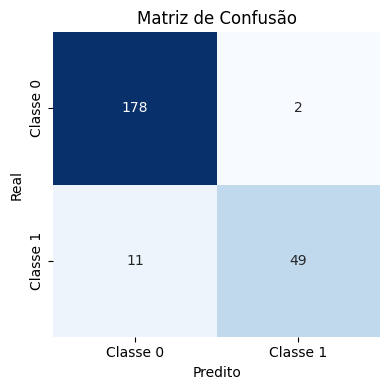

In [52]:
import seaborn as sns

matriz_confusao = confusion_matrix(saidas, previsoes)

plt.figure(figsize=(4, 4))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Classe 0", "Classe 1"],
            yticklabels=["Classe 0", "Classe 1"])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()

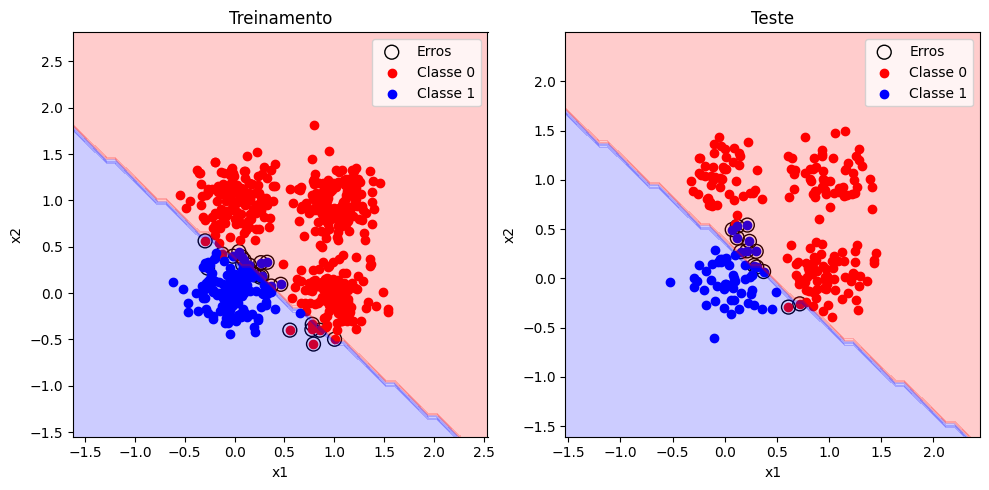

In [58]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['red', 'blue'])

X_train = dados_treinamento[:, :2]
y_train = dados_treinamento[:, 2]
X_test = entradas
y_test = saidas

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for ax, X, y, title in zip(axs, [X_train, X_test], [y_train, y_test], ['Treinamento', 'Teste']):
    y_pred = perceptron.prever(X)
    erros = y_pred != y

    ax.scatter(X[erros, 0], X[erros, 1], facecolors='none', edgecolors='black', s=100, label='Erros')
    ax.scatter(X[y==0, 0], X[y==0, 1], c='red', label='Classe 0')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='blue', label='Classe 1')

    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
    grade = np.c_[xx.ravel(), yy.ravel()]
    Z = perceptron.prever(grade)
    Z = np.array(Z).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.2, cmap=cmap)

    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend()

plt.tight_layout()
plt.show()

> 

> Acerca da solução, alguns pontos precisam ser levantados. Este é, claro, um problema não linearmente separável, o que já leva ao primeiro ponto: o Perceptron de Rosenblatt é um modelo linear.
> A fronteira de decisão tenta traçar uma linha que divide as classes e falha não somente na distinção dos conjuntos, como na separação dos pontos. Há pontos da Classe 1 para fora dos limites da reta e vice-versa, preditos erroneamente e distintos pelos círculos pretos. Os erros eram esperados, dado um modelo linear para um problema não linearmente separável. 
> O modelo terminou com boa acurácia e precisão, ambas acima dos 90%. É pela discrepância de valores que recall e f1-score devem receber maior atenção. A diferença se deve, muito provavelmente, ao desbalanceamento do dataset; a maior parte dos dados é para a Classe 0, vermelha. O MO do Perceptron é simples, ele adapta seus pesos a cada previsão e não diferencia as classes entre si. Isso significa que classes 0 e 1 são tratadas como um só conjunto que dispõe de saídas diferentes, e se boa parte dos dados exige saída 0, talvez isso enviese um pouco o modelo e justifique o recall de 82% (ocasionado pelo 18% de falsos negativos) e por conseguinte o f1-score de 88%.
> Entretanto, os resultados podem ser vistos como satisfatórios para a solução, ainda que muito provavelmente não seja ideal tentar se utilizar de um modelo linear para um problema não linearmente separável.
